In [1]:
!pip3 install datasets

/bin/bash: /home/abhishek/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [4]:
from datasets import list_datasets, load_dataset
from pprint import pprint

# sst dataset

# sst_valid = load_dataset('sst', split='test')
# # convert to pandas dataframe
# sst_valid_df = sst_valid.to_pandas()
# # save to csv
# sst_valid_df.to_csv('sst_test.csv', index=False)

#multi_nli dataset

multi_nli_train = load_dataset('multi_nli', split='validation_mismatched')
# convert to pandas dataframe
multi_nli_train_df = multi_nli_train.to_pandas()
# save to csv
multi_nli_train_df.to_csv('multi_nli_test.csv', index=False)



Found cached dataset multi_nli (/home/abhishek/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39)


In [160]:
# keep only the text and label column for sst dataset
# load the csv file in pandas dataframe
import pandas as pd 

sst_train_df = pd.read_csv('sst_train.csv')
sst_valid_df = pd.read_csv('sst_valid.csv')
sst_test_df = pd.read_csv('sst_test.csv')

sst_train_df = sst_train_df[['sentence','label']]
sst_valid_df = sst_valid_df[['sentence','label']]
sst_test_df = sst_test_df[['sentence','label']]
# save to csv
sst_train_df.to_csv('sst_train.csv', index=False)
sst_valid_df.to_csv('sst_valid.csv', index=False)
sst_test_df.to_csv('sst_test.csv', index=False)


In [175]:
def change_label(x):
    if x<=0.5:
        return 0
    else:
        return 1
        

In [176]:
# in sst_split change the labels according to threshold, divide them into 3 classes
# 0 - negative, 1 - neutral, 2 - positive
import pandas as pd

sst_train_df = pd.read_csv('sst_train.csv')
sst_valid_df = pd.read_csv('sst_valid.csv')
sst_test_df = pd.read_csv('sst_test.csv')

sst_train_df['label'] = sst_train_df['label'].apply(change_label)
sst_valid_df['label'] = sst_valid_df['label'].apply(change_label)
sst_test_df['label'] = sst_test_df['label'].apply(change_label)


sst_train_df.to_csv('sst_train_label.csv', index=False)
sst_valid_df.to_csv('sst_valid_label.csv', index=False)
sst_test_df.to_csv('sst_test_label.csv', index=False)

In [11]:
# multi_nli dataset
# keep premise and label 
import pandas as pd 
multi_nli_train_df = pd.read_csv('multi_nli_test.csv')

# multi_nli_train_df = multi_nli_train_df[['premise','hypothesis','label']]

# multi_nli_train_df.to_csv('multi_nli_valid.csv', index=False)

# premise + hypothesis = sentence
multi_nli_train_df['sentence'] = multi_nli_train_df['premise'] + ' ' + multi_nli_train_df['hypothesis']
multi_nli_train_df = multi_nli_train_df[['sentence','label']]
multi_nli_train_df.to_csv('multi_nli_test.csv', index=False)


In [21]:
multi_nli_train_df = pd.read_csv('multi_nli_valid.csv')
# if sentence is empty, drop it
multi_nli_train_df = multi_nli_train_df.dropna()
multi_nli_train_df.to_csv('multi_nli_valid.csv', index=False)


In [1]:
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

class PreProcessing():
    def __init__(self,filePath,savePath,minFreq):
        self.filePath = filePath
        self.savePath = savePath
        self.minFreq = minFreq
        self.word2idx = {}
        self.idx2word = {}
        self.word2count = {}
        self.vocab = []
        self.vocabSize = 0
        self.word2idx['<PAD>'] = 0
        self.word2idx['<UNK>'] = 1
        self.idx2word[0] = '<PAD>'
        self.idx2word[1] = '<UNK>'
        self.vocabSize = 2
        self.word2count['<PAD>'] = 0
        self.word2count['<UNK>'] = 0
        self.vocab.append('<PAD>')
        self.vocab.append('<UNK>')
        self.tokens = []
        self.label = []
        self.removeWords()


    def removeWords(self):

        stop_words = set(stopwords.words('english'))
        punctuations = set(string.punctuation)
        ps = PorterStemmer()
        data = pd.read_csv(self.filePath)

        preProcessedData = []
        for sentence in tqdm(data['sentence'],desc='Preprocessing'):
            tokens = word_tokenize(sentence)
            filtered_tokens = [token.lower() for token in tokens if token not in stop_words and token not in punctuations]
            preProcessed_sentence = ' '.join(filtered_tokens)
            preProcessedData.append(preProcessed_sentence)


        word_counts = {}
        for sentence in preProcessedData:
            tokens = word_tokenize(sentence)
            for token in tokens:
                if token not in word_counts:
                    word_counts[token] = 1
                else:
                    word_counts[token] += 1

        for word,count in word_counts.items():
            if count >= self.minFreq:
                self.word2idx[word] = self.vocabSize
                self.word2count[word] = count
                self.idx2word[self.vocabSize] = word
                self.vocabSize += 1
                self.vocab.append(word)



class GetDatasets(Dataset):
    def __init__(self,filePath,vocab,word2idx,pad):
        self.filePath = filePath
        self.vocab = vocab
        self.word2idx = word2idx
        self.tokens = []
        self.label = []
        self.pad = pad
        self.forward_data = []
        self.backward_data = []

        data = pd.read_csv(self.filePath)
        maxLen = 0
        print(data.shape)
        for sentence in data['sentence']:

            tokens = word_tokenize(sentence)
            if len(tokens) > maxLen:
                maxLen = len(tokens)
        for i in tqdm(range(data.shape[0]),desc='Tokenising and Padding'):
            sentence = data['sentence'][i]
            tokens = word_tokenize(sentence)
            for j in range(len(tokens)):
                if tokens[j] in self.word2idx:
                    tokens[j] = self.word2idx[tokens[j]]
                else:
                    tokens[j] = self.word2idx['<UNK>']

            if self.pad:
                tokens.extend([self.word2idx['<PAD>']]*(maxLen-len(tokens)))

            data['sentence'][i] = tokens
            self.tokens.append(tokens)
            self.label.append(data['label'][i])
            self.forward_data.append(tokens[1:])
            self.backward_data.append(tokens[:-1])
            


        self.label = torch.tensor(self.label)
        self.tokens = torch.tensor(self.tokens)
        self.forward_data = torch.tensor(self.forward_data)
        self.backward_data = torch.tensor(self.backward_data)


    def __getitem__(self, index):
        return self.tokens[index], self.label[index],self.forward_data[index],self.backward_data[index]

    def __len__(self):
        return self.tokens.shape[0]


# preProcessing = PreProcessing('sst_train_label.csv', 'sst_train_label.csv', 4)
# train_data = GetDatasets('sst_train_label.csv',
#                          preProcessing.vocab, preProcessing.word2idx, True)
# valid_data = GetDatasets('sst_valid_label.csv',
#                          preProcessing.vocab, preProcessing.word2idx, True)
# test_data = GetDatasets('sst_test_label.csv',
#                         preProcessing.vocab, preProcessing.word2idx, True)

# do for multi_nli dataset
preProcessing = PreProcessing('multi_nli_train.csv','multi_nli_train.csv',5)
train_data = GetDatasets('multi_nli_train.csv',preProcessing.vocab,preProcessing.word2idx,True)
valid_data = GetDatasets('multi_nli_valid.csv',preProcessing.vocab,preProcessing.word2idx,True)
test_data = GetDatasets('multi_nli_test.csv',   
                        preProcessing.vocab, preProcessing.word2idx, True)

    


Preprocessing: 100%|██████████| 25224/25224 [00:08<00:00, 2823.16it/s]


(25224, 2)


Tokenising and Padding:   0%|          | 0/25224 [00:00<?, ?it/s]/tmp/ipykernel_187639/395167919.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentence'][i] = tokens
Tokenising and Padding: 100%|██████████| 25224/25224 [00:22<00:00, 1144.60it/s]


(9815, 2)


Tokenising and Padding:   0%|          | 0/9815 [00:00<?, ?it/s]/tmp/ipykernel_187639/395167919.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentence'][i] = tokens
Tokenising and Padding: 100%|██████████| 9815/9815 [00:09<00:00, 1003.57it/s]


(9832, 2)


Tokenising and Padding:   0%|          | 0/9832 [00:00<?, ?it/s]/tmp/ipykernel_187639/395167919.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentence'][i] = tokens
Tokenising and Padding: 100%|██████████| 9832/9832 [00:11<00:00, 833.46it/s] 


In [5]:
VOCAB_SIZE = preProcessing.vocabSize
BATCH_SIZE = 16
EMBEDDING_DIM = 300
HIDDEN_DIM = 100
    

In [6]:
train_dataloader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=False)
valid_dataloader = torch.utils.data.DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


In [5]:
tokens_test, label_test, forward_data_test, backward_data_test = next(iter(test_dataloader))

In [9]:
# load the glove embeddings
import numpy as np 
glove_file = './glove.6B/glove.6B.300d.txt'
glove_dict = {}
with open(glove_file, 'r',encoding = 'utf-8') as f:
    for line in f:
        tokens = line.strip().split(' ')
        word = tokens[0]
        embedding = np.array([float(val) for val in tokens[1:]])
        glove_dict[word] = embedding

# UNK and PAD embedding
UNK_emb = np.mean(list(glove_dict.values()), axis=0)
PAD_emb = np.zeros(300)


In [10]:
import torch
import torch.nn as nn
import tqdm

print(len(glove_dict))
cnt = 0

vocab = preProcessing.vocab
embeddings = []
for word in vocab:
    if word == '<UNK>':
        embeddings.append(UNK_emb)
    elif word == '<PAD>':
        embeddings.append(PAD_emb)
    elif word in glove_dict:
        cnt += 1
        embeddings.append(glove_dict[word])
    else:
        emb = np.random.uniform(-0.25,0.25,300)
        embeddings.append(emb)
    

print(cnt)


400000
10296


In [11]:
embeddings = torch.tensor(embeddings, dtype=torch.float)
# embeddings = torch.stack(embeddings)
embedding = nn.Embedding.from_pretrained(
    embeddings, freeze=False, padding_idx=0)

print(embedding.weight.shape)
# save the embedding
torch.save(embedding, 'embeddings2.pt')


torch.Size([10394, 300])


/tmp/ipykernel_182920/1509447340.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)


In [7]:
# laod from pickle 
import pickle 
embeddings = torch.load('embeddings2.pt')

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [10]:
class ELMo(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size, embedding_matrix):
        super(ELMo, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.embedding = embedding_matrix
        self.embedding.weight = nn.Parameter(
            self.embedding.weight, requires_grad=True)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim,
                             batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim*2, hidden_dim,
                             batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)
        self.linear_out = nn.Linear(hidden_dim*2, vocab_size)

    def forward(self, back_data):
        back_embed = self.embedding(back_data)
        back_lstm1, _ = self.lstm1(back_embed)
        back_lstm2, _ = self.lstm2(back_lstm1)
        linear_out = self.linear_out(back_lstm2)
        return linear_out


In [12]:
elmo = ELMo(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, BATCH_SIZE, embeddings)
print(elmo)
elmo.to(device)

ELMo(
  (embedding): Embedding(10394, 300, padding_idx=0)
  (lstm1): LSTM(300, 100, batch_first=True, bidirectional=True)
  (lstm2): LSTM(200, 100, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=300, out_features=100, bias=True)
  (linear_out): Linear(in_features=200, out_features=10394, bias=True)
)


ELMo(
  (embedding): Embedding(10394, 300, padding_idx=0)
  (lstm1): LSTM(300, 100, batch_first=True, bidirectional=True)
  (lstm2): LSTM(200, 100, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=300, out_features=100, bias=True)
  (linear_out): Linear(in_features=200, out_features=10394, bias=True)
)

In [13]:
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch

def train_epoch(model, train_dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    iter = 0
    for (tokens, label, forward, backward) in tqdm(train_dataloader, desc='Training'):
        forward = forward.to(device)
        backward = backward.to(device)
        optimizer.zero_grad()
        output = model(backward)
        loss = criterion(output.view(-1, VOCAB_SIZE), forward.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        iter += 1
        if iter%1000 == 0:
            print('Iteration: ', iter, 'Train Loss: ', total_loss/iter)
    return total_loss/len(train_dataloader)

def validate_epoch(model, valid_dataloader, criterion):
    model.eval()
    total_loss = 0
    iter = 0
    with torch.no_grad():
        for (tokens, label, forward, backward) in tqdm(valid_dataloader, desc='Validating'):
            forward = forward.to(device)
            backward = backward.to(device)
            output = model(backward)
            loss = criterion(output.view(-1, VOCAB_SIZE), forward.view(-1))
            total_loss += loss.item()
            iter += 1
            if iter%500 == 0:
                print('Iteration: ', iter, 'Validation Loss: ', total_loss/iter)
    return total_loss/len(valid_dataloader)

def train_model(model, train_dataloader, valid_dataloader, optimizer, criterion, epochs):
    best_valid_loss = float('inf')
    losses = {'epoch': [], 'train_loss': [], 'valid_loss': []}
    for epoch in range(epochs):
        print('Epoch: ', epoch)
        train_loss = train_epoch(model, train_dataloader, optimizer, criterion)
        valid_loss = validate_epoch(model, valid_dataloader, criterion)
        print('Train Loss: ', train_loss, 'Valid Loss: ', valid_loss)
        losses['epoch'].append(epoch)
        losses['train_loss'].append(train_loss)
        losses['valid_loss'].append(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            # torch.save(model.state_dict(), 'elmo_model1.pt')
            # print('Model saved')
    return losses

optimizer = optim.Adam(elmo.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
losses = train_model(elmo, train_dataloader, valid_dataloader, optimizer, criterion, 10)


Epoch:  0


Training:  63%|██████▎   | 1000/1577 [04:22<02:42,  3.54it/s]

Iteration:  1000 Train Loss:  4.052580119371414


Validating:  82%|████████▏ | 501/614 [00:46<00:10, 10.80it/s]

Iteration:  500 Validation Loss:  1.7731063113212586


Validating: 100%|██████████| 614/614 [00:57<00:00, 10.75it/s]


Train Loss:  3.361974797448404 Valid Loss:  1.772004680835463
Epoch:  1


Training:  63%|██████▎   | 1000/1577 [05:57<02:58,  3.23it/s]

Iteration:  1000 Train Loss:  1.4833122106790542


Validating:  82%|████████▏ | 502/614 [00:50<00:10, 10.62it/s]

Iteration:  500 Validation Loss:  0.8355827458500862


Validating: 100%|██████████| 614/614 [01:00<00:00, 10.08it/s]


Train Loss:  1.3108257232546883 Valid Loss:  0.8362675080567307
Epoch:  2


Training:  63%|██████▎   | 1000/1577 [06:07<03:11,  3.02it/s]

Iteration:  1000 Train Loss:  0.7126220746040344


Validating:  82%|████████▏ | 502/614 [00:48<00:09, 11.49it/s]

Iteration:  500 Validation Loss:  0.3990166934728622


Validating: 100%|██████████| 614/614 [00:58<00:00, 10.49it/s]


Train Loss:  0.6281970211918322 Valid Loss:  0.3996662477377183
Epoch:  3


Training:  63%|██████▎   | 1000/1577 [06:14<03:24,  2.82it/s]

Iteration:  1000 Train Loss:  0.33300331796705723


Validating:  81%|████████▏ | 500/614 [00:56<00:12,  9.16it/s]

Iteration:  500 Validation Loss:  0.19104647497832775


Validating: 100%|██████████| 614/614 [01:08<00:00,  8.92it/s]


Train Loss:  0.2925741758549523 Valid Loss:  0.19144915902216583
Epoch:  4


Training:  63%|██████▎   | 1000/1577 [06:25<04:17,  2.24it/s]

Iteration:  1000 Train Loss:  0.14857424325868487


Validating:  81%|████████▏ | 500/614 [00:55<00:10, 10.80it/s]

Iteration:  500 Validation Loss:  0.09733067148923874


Validating: 100%|██████████| 614/614 [01:09<00:00,  8.84it/s]


Train Loss:  0.13112304831182345 Valid Loss:  0.09765873766877364
Epoch:  5


Training:  63%|██████▎   | 1000/1577 [06:10<03:35,  2.68it/s]

Iteration:  1000 Train Loss:  0.06647117310389876


Validating:  82%|████████▏ | 502/614 [00:48<00:09, 12.00it/s]

Iteration:  500 Validation Loss:  0.055183960914611814


Validating: 100%|██████████| 614/614 [00:58<00:00, 10.45it/s]


Train Loss:  0.05917614656716075 Valid Loss:  0.055352301773666755
Epoch:  6


Training:  63%|██████▎   | 1000/1577 [05:47<03:36,  2.66it/s]

Iteration:  1000 Train Loss:  0.031201272130012513


Validating:  81%|████████▏ | 500/614 [00:54<00:10, 11.08it/s]

Iteration:  500 Validation Loss:  0.03476123230718076


Validating: 100%|██████████| 614/614 [01:05<00:00,  9.36it/s]


Train Loss:  0.028185525038276642 Valid Loss:  0.03490119182022367
Epoch:  7


Training:  63%|██████▎   | 1000/1577 [04:52<02:34,  3.74it/s]

Iteration:  1000 Train Loss:  0.01602744391700253


Validating:  82%|████████▏ | 502/614 [00:38<00:08, 13.13it/s]

Iteration:  500 Validation Loss:  0.023104527837596835


Validating: 100%|██████████| 614/614 [00:46<00:00, 13.11it/s]


Train Loss:  0.014578892044591929 Valid Loss:  0.023317882173060644
Epoch:  8


Training:  63%|██████▎   | 1000/1577 [04:25<02:21,  4.07it/s]

Iteration:  1000 Train Loss:  0.008252783900825306


Validating:  82%|████████▏ | 502/614 [00:39<00:08, 12.81it/s]

Iteration:  500 Validation Loss:  0.016938646108377725


Validating: 100%|██████████| 614/614 [00:48<00:00, 12.70it/s]


Train Loss:  0.007629050060896441 Valid Loss:  0.017159824355896743
Epoch:  9


Training:  63%|██████▎   | 1000/1577 [04:37<02:29,  3.85it/s]

Iteration:  1000 Train Loss:  0.004662436975515448


Validating:  82%|████████▏ | 502/614 [00:38<00:08, 12.91it/s]

Iteration:  500 Validation Loss:  0.013555558792781084


Validating: 100%|██████████| 614/614 [00:47<00:00, 12.92it/s]

Train Loss:  0.004420157069737208 Valid Loss:  0.013795549054523924


In [14]:
torch.save(elmo.state_dict(), 'elmo_model2.pt')

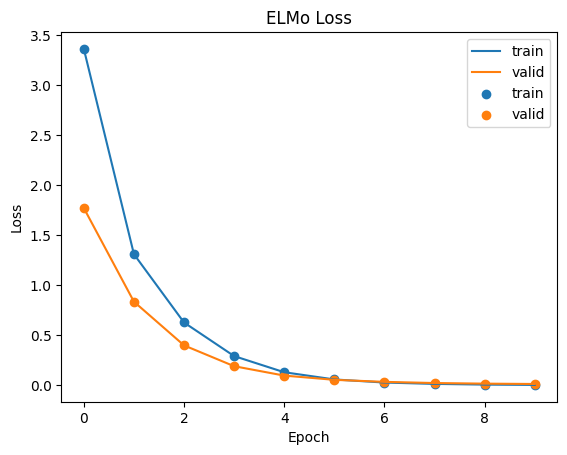

<Figure size 640x480 with 0 Axes>

In [15]:
from matplotlib import pyplot as plt
plt.plot(losses['epoch'], losses['train_loss'], label='train')
plt.plot(losses['epoch'], losses['valid_loss'], label='valid')
# mark with circle 
plt.scatter(losses['epoch'], losses['train_loss'], label='train')
plt.scatter(losses['epoch'], losses['valid_loss'], label='valid')
plt.title('ELMo Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('elmo1_loss.png')


In [15]:
elmo.load_state_dict(torch.load('elmo_model1.pt'))

<All keys matched successfully>

In [16]:
# Parameters
for name, param in elmo.named_parameters():
    if param.requires_grad:
        print(name, param.data, param.shape)
elmo_embeddings = list(elmo.parameters())[0].cpu().detach().numpy()
torch.save(elmo_embeddings, 'elmo_embeddings2.pt')


embedding.weight tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0455, -0.0049, -0.3074,  ...,  0.1832,  0.0994, -0.0489],
        [-0.3970,  0.6153,  0.0971,  ..., -0.1090, -0.3179,  0.0442],
        ...,
        [-0.4002, -0.3347,  0.0580,  ...,  0.0591, -0.2369,  0.4198],
        [-0.9068, -0.0600,  0.9909,  ...,  0.0420, -0.1341, -0.2229],
        [-0.0623, -0.1463, -0.2567,  ..., -0.1825, -0.0501,  0.2171]],
       device='cuda:0') torch.Size([10394, 300])
lstm1.weight_ih_l0 tensor([[-0.2193,  0.0715, -0.2751,  ..., -0.3162, -0.1039,  0.1265],
        [-0.0056, -0.0766, -0.1295,  ..., -0.1505,  0.0042,  0.0200],
        [-0.0618,  0.0704, -0.0109,  ..., -0.0442,  0.0191, -0.0406],
        ...,
        [-0.2929, -0.2009, -0.1878,  ...,  0.0911, -0.1584,  0.2816],
        [-0.0838, -0.2634, -0.3747,  ...,  0.2951,  0.0694,  0.2606],
        [-0.1113,  0.2053, -0.2024,  ...,  0.0076,  0.0921,  0.1604]],
       device='cuda:0') torch.Size([400, 300])


In [17]:
elmo_lstm1 = elmo.lstm1
print(elmo_lstm1.parameters())
elmo_lstm2 = elmo.lstm2
print(elmo_lstm2.parameters())
elmo_embeddings = list(elmo.parameters())[0].to(device)


<generator object Module.parameters at 0x7f91dc0c2f10>
<generator object Module.parameters at 0x7f91dc0c2f10>


In [18]:
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score
class scoreClassifier(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,elmoEmbedding,elmo_lstm1,elmo_lstm2,num_classes):
        super(scoreClassifier,self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding.from_pretrained(elmoEmbedding, padding_idx=0)
        self.embeddings.weight = nn.Parameter(self.embeddings.weight,requires_grad=
                                              False)
        self.weights = nn.Parameter(torch.tensor([0.33,0.33,0.33]),requires_grad=False)
        self.lstm1 = elmo_lstm1
        self.lstm2 = elmo_lstm2
        self.linear1 = nn.Linear(embedding_dim, hidden_dim*2)
        self.linear_out = nn.Linear(hidden_dim*2, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self,input_data):
        embed = self.embeddings(input_data)
        embedChange = self.linear1(embed)
        lstm1, _ = self.lstm1(embed)
        lstm2, _ = self.lstm2(lstm1)
        elmo_out = (self.weights[0]*lstm1 + self.weights[1]*lstm2 + self.weights[2]*embedChange)/(self.weights[0]+self.weights[1]+self.weights[2])
        elmo_max = torch.max(elmo_out, dim=1)[0]
        elmo_max = self.dropout(elmo_max)
        linear_out = self.linear_out(elmo_max)

        l2_reg = torch.tensor(0.).to(device)
        for param in self.linear1.parameters():
            l2_reg += torch.norm(param,2)
        for param in self.linear_out.parameters():
            l2_reg += torch.norm(param,2)

        # scores = self.relu(linear_out)
        return linear_out, l2_reg


In [19]:
classifier = scoreClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, elmo_embeddings, elmo_lstm1, elmo_lstm2, 3)
print(classifier)

scoreClassifier(
  (embeddings): Embedding(10394, 300, padding_idx=0)
  (lstm1): LSTM(300, 100, batch_first=True, bidirectional=True)
  (lstm2): LSTM(200, 100, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=300, out_features=200, bias=True)
  (linear_out): Linear(in_features=200, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [20]:
classifier.to(device)
#Initializing optimizer
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
#Initializing loss function
criterion = nn.CrossEntropyLoss()



In [21]:
def train_classifier_epoch(model, train_dataloader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    iter = 0
    total_acc = 0 
    for batch in tqdm(train_dataloader,desc="Training"):
        optimizer.zero_grad()
        batch = tuple(t.to(device) for t in batch)
        input_data,labels,_,_ = batch
        logits,l2_reg = model(input_data)
        loss = criterion(logits, labels) + 0.001*l2_reg
        loss.backward()
        optimizer.step()
        _,preds = torch.max(logits, dim=1)
        train_acc = accuracy_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())
        total_acc += train_acc
        train_loss += loss.item()
        iter += 1
        if iter % 1000 == 0:
            print("Iteration: {}, Train Loss: {}".format(iter, loss.item()))

    return train_loss/len(train_dataloader), total_acc/len(train_dataloader)

def eval_classifier_epoch(model, val_dataloader, criterion, device):
    model.eval()
    losses = 0
    iter = 0
    total_acc = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader,desc="Validation"):
            batch = tuple(t.to(device) for t in batch)
            input_data,labels,_,_ = batch
            logits,_ = model(input_data)
 
            _,preds = torch.max(logits, dim=1)
            val_acc = accuracy_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())
            total_acc += val_acc
            loss = criterion(logits, labels) 
            losses += loss.item()
            iter += 1
            if iter % 500 == 0:
                print("Iteration: {}, Validation Loss: {}".format(iter, loss.item()))
    return losses/len(val_dataloader), total_acc/len(val_dataloader)

def train_classifier(model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=10):

    losses = {'epoch': [], 'train_loss': [], 'valid_loss': []}
    acc = {'epoch': [], 'train_acc': [], 'valid_acc': []}
    min_valid_loss = float('inf')
    for epoch in range(epochs):
        print("Epoch: {}".format(epoch))

        train_loss,train_acc = train_classifier_epoch(model, train_dataloader, optimizer, criterion, device)
        val_loss,val_acc = eval_classifier_epoch(model, val_dataloader, criterion, device)
        if val_loss < min_valid_loss:
            min_valid_loss = val_loss
            print("Saving model...")
            torch.save(model.state_dict(), 'elmo2_classifier.pt')

        print("Train Loss: {}, Train Accuracy: {}".format(train_loss,train_acc))
        print("Validation Loss: {}, Validation Accuracy: {}".format(val_loss,val_acc))
        losses['epoch'].append(epoch)
        losses['train_loss'].append(train_loss)
        losses['valid_loss'].append(val_loss)
        acc['epoch'].append(epoch)
        acc['train_acc'].append(train_acc)
        acc['valid_acc'].append(val_acc)
        
    return losses,acc 

train_losses = train_classifier(classifier, train_dataloader, valid_dataloader, optimizer, criterion, device, epochs=20)


Epoch: 0


Training:  63%|██████▎   | 1001/1577 [01:18<00:50, 11.45it/s]

Iteration: 1000, Train Loss: 1.088045358657837


Validation:  82%|████████▏ | 504/614 [00:15<00:03, 31.81it/s]

Iteration: 500, Validation Loss: 1.0504320859909058


Validation: 100%|██████████| 614/614 [00:18<00:00, 32.91it/s]


Saving model...
Train Loss: 1.089786513855583, Train Accuracy: 0.4126109701965758
Validation Loss: 1.0637284170727, Validation Accuracy: 0.43873604001861327
Epoch: 1


Training:  63%|██████▎   | 1001/1577 [01:48<01:12,  7.99it/s]

Iteration: 1000, Train Loss: 0.968433141708374


Validation:  82%|████████▏ | 503/614 [00:17<00:03, 30.07it/s]

Iteration: 500, Validation Loss: 1.0869174003601074


Validation: 100%|██████████| 614/614 [00:20<00:00, 29.58it/s]


Saving model...
Train Loss: 1.0576217077015773, Train Accuracy: 0.46092263792010146
Validation Loss: 1.0588408991063456, Validation Accuracy: 0.4431421591437878
Epoch: 2


Training:  63%|██████▎   | 1001/1577 [01:38<00:56, 10.16it/s]

Iteration: 1000, Train Loss: 0.9333668351173401


Validation:  82%|████████▏ | 503/614 [00:23<00:04, 23.76it/s]

Iteration: 500, Validation Loss: 1.1364363431930542


Validation: 100%|██████████| 614/614 [00:28<00:00, 21.81it/s]


Saving model...
Train Loss: 1.0415095099181257, Train Accuracy: 0.4759432466708941
Validation Loss: 1.04403480984489, Validation Accuracy: 0.45556072591903213
Epoch: 3


Training:  64%|██████▎   | 1002/1577 [01:59<00:55, 10.39it/s]

Iteration: 1000, Train Loss: 0.9904614686965942


Validation:  82%|████████▏ | 504/614 [00:16<00:03, 29.92it/s]

Iteration: 500, Validation Loss: 1.1408872604370117


Validation: 100%|██████████| 614/614 [00:20<00:00, 29.80it/s]


Saving model...
Train Loss: 1.0206241776993097, Train Accuracy: 0.49829581483830054
Validation Loss: 1.0355752716235307, Validation Accuracy: 0.468822708236389
Epoch: 4


Training:  63%|██████▎   | 1000/1577 [01:40<00:58,  9.86it/s]

Iteration: 1000, Train Loss: 1.0592377185821533


Validation:  82%|████████▏ | 506/614 [00:16<00:03, 29.90it/s]

Iteration: 500, Validation Loss: 1.1307392120361328


Validation: 100%|██████████| 614/614 [00:20<00:00, 29.85it/s]


Saving model...
Train Loss: 1.0043412014964872, Train Accuracy: 0.5111366518706405
Validation Loss: 1.021337563711968, Validation Accuracy: 0.48375697999069334
Epoch: 5


Training:  63%|██████▎   | 1001/1577 [01:43<00:59,  9.68it/s]

Iteration: 1000, Train Loss: 0.9088965058326721


Validation:  82%|████████▏ | 505/614 [00:16<00:03, 29.44it/s]

Iteration: 500, Validation Loss: 1.1027864217758179


Validation: 100%|██████████| 614/614 [00:20<00:00, 29.75it/s]


Saving model...
Train Loss: 0.9863987704130691, Train Accuracy: 0.5294071020925808
Validation Loss: 1.0202156558681388, Validation Accuracy: 0.48212831549557933
Epoch: 6


Training:  63%|██████▎   | 1001/1577 [01:43<00:59,  9.63it/s]

Iteration: 1000, Train Loss: 1.0335534811019897


Validation:  82%|████████▏ | 504/614 [00:17<00:03, 29.00it/s]

Iteration: 500, Validation Loss: 1.0516929626464844


Validation: 100%|██████████| 614/614 [00:21<00:00, 29.02it/s]


Train Loss: 0.9714187198828199, Train Accuracy: 0.5417327203551047
Validation Loss: 1.0268686040993233, Validation Accuracy: 0.47991798510935313
Epoch: 7


Training:  63%|██████▎   | 1001/1577 [01:54<01:03,  9.04it/s]

Iteration: 1000, Train Loss: 0.9987518787384033


Validation:  82%|████████▏ | 504/614 [00:18<00:04, 26.93it/s]

Iteration: 500, Validation Loss: 0.9914430975914001


Validation: 100%|██████████| 614/614 [00:22<00:00, 26.86it/s]


Train Loss: 0.949927386484648, Train Accuracy: 0.559289790741915
Validation Loss: 1.026165049025601, Validation Accuracy: 0.4833207305723592
Epoch: 8


Training:  63%|██████▎   | 1001/1577 [01:56<01:07,  8.57it/s]

Iteration: 1000, Train Loss: 0.8761202692985535


Validation:  82%|████████▏ | 504/614 [00:20<00:04, 24.44it/s]

Iteration: 500, Validation Loss: 0.9859548807144165


Validation: 100%|██████████| 614/614 [00:24<00:00, 24.68it/s]


Train Loss: 0.9336738029309444, Train Accuracy: 0.5741518706404566
Validation Loss: 1.022763062474782, Validation Accuracy: 0.48823580735225686
Epoch: 9


Training:  63%|██████▎   | 1001/1577 [02:07<01:13,  7.84it/s]

Iteration: 1000, Train Loss: 0.9779234528541565


Validation:  82%|████████▏ | 504/614 [00:20<00:04, 23.86it/s]

Iteration: 500, Validation Loss: 1.0036139488220215


Validation: 100%|██████████| 614/614 [00:25<00:00, 23.87it/s]


Train Loss: 0.9146559360893602, Train Accuracy: 0.5873890298034242
Validation Loss: 1.0412883885714441, Validation Accuracy: 0.4819683573755235
Epoch: 10


Training:  63%|██████▎   | 1001/1577 [02:09<01:06,  8.67it/s]

Iteration: 1000, Train Loss: 0.9260147213935852


Validation:  82%|████████▏ | 504/614 [00:18<00:04, 27.13it/s]

Iteration: 500, Validation Loss: 0.9292402863502502


Validation: 100%|██████████| 614/614 [00:22<00:00, 27.12it/s]


Train Loss: 0.8907365781752914, Train Accuracy: 0.6034004438807863
Validation Loss: 1.0312746970001183, Validation Accuracy: 0.49146405304792923
Epoch: 11


Training:  63%|██████▎   | 1001/1577 [01:55<01:06,  8.65it/s]

Iteration: 1000, Train Loss: 0.8119637370109558


Validation:  82%|████████▏ | 505/614 [00:18<00:04, 25.03it/s]

Iteration: 500, Validation Loss: 0.9579601287841797


Validation: 100%|██████████| 614/614 [00:22<00:00, 27.54it/s]


Train Loss: 0.8744326077198483, Train Accuracy: 0.6139426125554851
Validation Loss: 1.0398310266605029, Validation Accuracy: 0.4883375988832015
Epoch: 12


Training:  63%|██████▎   | 1001/1577 [01:54<01:05,  8.74it/s]

Iteration: 1000, Train Loss: 0.7856048345565796


Validation:  82%|████████▏ | 504/614 [00:18<00:03, 27.60it/s]

Iteration: 500, Validation Loss: 0.9596471190452576


Validation: 100%|██████████| 614/614 [00:22<00:00, 27.46it/s]


Train Loss: 0.856863392896114, Train Accuracy: 0.6259908053265695
Validation Loss: 1.0520462425795751, Validation Accuracy: 0.48683980921358766
Epoch: 13


Training:  63%|██████▎   | 1001/1577 [01:54<01:05,  8.76it/s]

Iteration: 1000, Train Loss: 0.7993435263633728


Validation:  82%|████████▏ | 504/614 [00:18<00:03, 27.70it/s]

Iteration: 500, Validation Loss: 0.9739694595336914


Validation: 100%|██████████| 614/614 [00:22<00:00, 27.60it/s]


Train Loss: 0.8270682887178323, Train Accuracy: 0.6448557387444515
Validation Loss: 1.0848272724337997, Validation Accuracy: 0.4819974406700791
Epoch: 14


Training:  64%|██████▎   | 1002/1577 [01:45<00:56, 10.12it/s]

Iteration: 1000, Train Loss: 0.9523743391036987


Validation:  82%|████████▏ | 504/614 [00:18<00:04, 27.42it/s]

Iteration: 500, Validation Loss: 0.9560360908508301


Validation: 100%|██████████| 614/614 [00:22<00:00, 27.46it/s]


Train Loss: 0.8091439559214767, Train Accuracy: 0.6554375396322131
Validation Loss: 1.0864994560856773, Validation Accuracy: 0.4772423220102373
Epoch: 15


Training:  64%|██████▎   | 1002/1577 [01:44<00:57, 10.04it/s]

Iteration: 1000, Train Loss: 0.6394078731536865


Validation:  82%|████████▏ | 506/614 [00:17<00:03, 29.79it/s]

Iteration: 500, Validation Loss: 0.968315839767456


Validation: 100%|██████████| 614/614 [00:20<00:00, 29.40it/s]


Train Loss: 0.7850682848831786, Train Accuracy: 0.6721227013316423
Validation Loss: 1.1093610898873705, Validation Accuracy: 0.4766606561191251
Epoch: 16


Training:  63%|██████▎   | 1001/1577 [01:43<00:59,  9.72it/s]

Iteration: 1000, Train Loss: 0.7439976930618286


Validation:  82%|████████▏ | 505/614 [00:17<00:03, 29.26it/s]

Iteration: 500, Validation Loss: 1.0865638256072998


Validation: 100%|██████████| 614/614 [00:20<00:00, 29.68it/s]


Train Loss: 0.7633384560472842, Train Accuracy: 0.6821100190234622
Validation Loss: 1.1135851680649997, Validation Accuracy: 0.4805723592368543
Epoch: 17


Training:  63%|██████▎   | 1001/1577 [01:43<00:59,  9.65it/s]

Iteration: 1000, Train Loss: 0.7436643242835999


Validation:  82%|████████▏ | 505/614 [00:17<00:03, 29.95it/s]

Iteration: 500, Validation Loss: 1.0248584747314453


Validation: 100%|██████████| 614/614 [00:20<00:00, 29.58it/s]


Train Loss: 0.7430285334624893, Train Accuracy: 0.6950301204819277
Validation Loss: 1.1434644144210442, Validation Accuracy: 0.47884190321079567
Epoch: 18


Training:  64%|██████▎   | 1002/1577 [01:42<00:55, 10.28it/s]

Iteration: 1000, Train Loss: 0.7255731821060181


Validation:  82%|████████▏ | 503/614 [00:17<00:03, 28.91it/s]

Iteration: 500, Validation Loss: 1.1113193035125732


Validation: 100%|██████████| 614/614 [00:21<00:00, 28.49it/s]


Train Loss: 0.7153410579520233, Train Accuracy: 0.7104470513633482
Validation Loss: 1.1493202100359268, Validation Accuracy: 0.4807759422987436
Epoch: 19


Training:  63%|██████▎   | 1001/1577 [01:50<01:08,  8.45it/s]

Iteration: 1000, Train Loss: 0.4434320032596588


Validation:  82%|████████▏ | 503/614 [00:17<00:03, 28.49it/s]

Iteration: 500, Validation Loss: 1.132580041885376


Validation: 100%|██████████| 614/614 [00:21<00:00, 28.32it/s]


Train Loss: 0.6846656315902705, Train Accuracy: 0.7265773620798985
Validation Loss: 1.1650834594176724, Validation Accuracy: 0.4819974406700791


In [25]:
# save the model
torch.save(classifier.state_dict(), 'elmo2_classifier.pt')

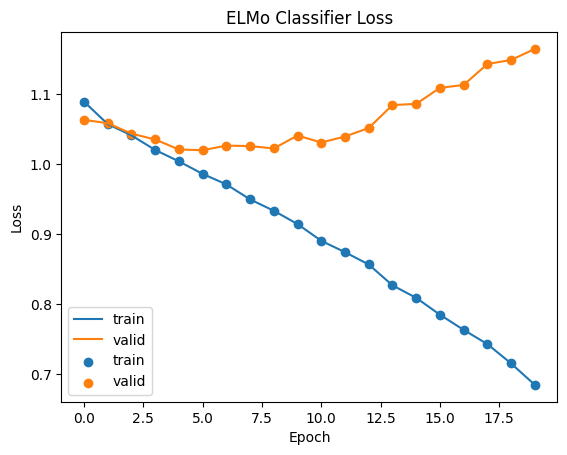

<Figure size 640x480 with 0 Axes>

In [22]:
# Plotting the loss
# train_losses = train_losses
losses,acc = train_losses
plt.plot(losses['epoch'], losses['train_loss'], label='train')
plt.plot(losses['epoch'], losses['valid_loss'], label='valid')
# mark with circle
plt.scatter(losses['epoch'], losses['train_loss'], label='train')
plt.scatter(losses['epoch'], losses['valid_loss'], label='valid')
plt.title('ELMo Classifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('elmo1_classifier_loss.png')

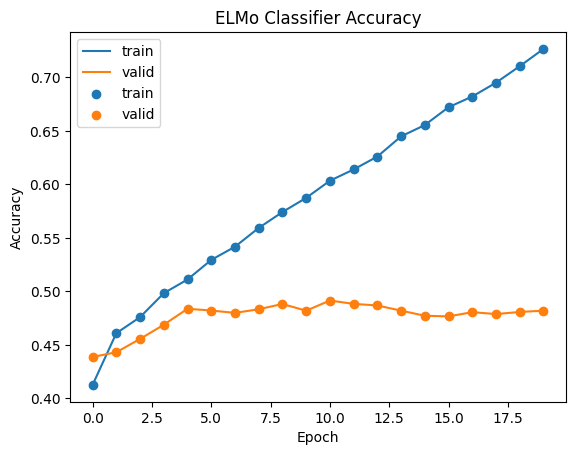

<Figure size 640x480 with 0 Axes>

In [23]:
# Plotting the accuracy
plt.plot(acc['epoch'], acc['train_acc'], label='train')
plt.plot(acc['epoch'], acc['valid_acc'], label='valid')
# mark with circle
plt.scatter(acc['epoch'], acc['train_acc'], label='train')
plt.scatter(acc['epoch'], acc['valid_acc'], label='valid')
plt.title('ELMo Classifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('elmo1_classifier_acc.png')


In [27]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np
classifier.load_state_dict(torch.load('elmo2_classifier.pt'))
classifier.eval()
y_true = []
y_pred = []
confusion_matrix = np.zeros((3,3))

with torch.no_grad():
    for batch in tqdm(test_dataloader,desc="Testing"):
        batch = tuple(t.to(device) for t in batch)
        input_data,labels,_,_ = batch
        logits,_ = classifier(input_data)
        _,preds = torch.max(logits, dim=1)
        y_true.extend(labels.cpu().detach().numpy())
        y_pred.extend(preds.cpu().detach().numpy())
        for i in range(len(labels)):
            confusion_matrix[labels[i]][preds[i]] += 1

print(classification_report(y_true, y_pred, target_names=['negative','neutral','positive'],zero_division=1))
print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
# print("F1 Score: {}".format(f1_score(y_true, y_pred),average='micro'))
# print("Precision: {}".format(precision_score(y_true, y_pred),average='micro'))
# print("Recall: {}".format(recall_score(y_true, y_pred),average='micro'))
print("Confusion Matrix: ")
print(confusion_matrix)

Testing: 100%|██████████| 615/615 [00:11<00:00, 51.64it/s]

              precision    recall  f1-score   support

    negative       0.48      0.57      0.52      3463
     neutral       0.47      0.38      0.42      3129
    positive       0.54      0.53      0.54      3240

    accuracy                           0.50      9832
   macro avg       0.50      0.50      0.49      9832
weighted avg       0.50      0.50      0.50      9832

Accuracy: 0.49857607811228644
Confusion Matrix: 
[[1976.  771.  716.]
 [1166. 1200.  763.]
 [ 941.  573. 1726.]]


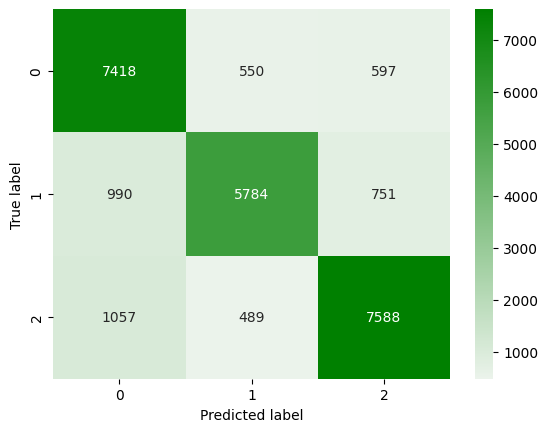

In [30]:
import seaborn as sns
cmap = sns.light_palette("green", as_cmap=True)
sns.heatmap(confusion_matrix, cmap=cmap, annot=True, fmt="g")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# assume y_true and y_scores are your true labels and predicted scores, respectively
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [29]:
classifier.eval()
y_true = []
y_pred = []
confusion_matrix = np.zeros((3, 3))

with torch.no_grad():
    for batch in tqdm(train_dataloader, desc="Testing"):
        batch = tuple(t.to(device) for t in batch)
        input_data, labels, _, _ = batch
        logits, _ = classifier(input_data)
        _, preds = torch.max(logits, dim=1)
        y_true.extend(labels.cpu().detach().numpy())
        y_pred.extend(preds.cpu().detach().numpy())
        for i in range(len(labels)):
            confusion_matrix[labels[i]][preds[i]] += 1

print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive'], zero_division=1))
print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
# print("F1 Score: {}".format(f1_score(y_true, y_pred)))
# print("Precision: {}".format(precision_score(y_true, y_pred)))
# print("Recall: {}".format(recall_score(y_true, y_pred)))
print("Confusion Matrix: ")
print(confusion_matrix)


Testing: 100%|██████████| 1577/1577 [00:50<00:00, 31.00it/s]


              precision    recall  f1-score   support

    negative       0.78      0.87      0.82      8565
     neutral       0.85      0.77      0.81      7525
    positive       0.85      0.83      0.84      9134

    accuracy                           0.82     25224
   macro avg       0.83      0.82      0.82     25224
weighted avg       0.83      0.82      0.82     25224

Accuracy: 0.8242150333016175
Confusion Matrix: 
[[7418.  550.  597.]
 [ 990. 5784.  751.]
 [1057.  489. 7588.]]


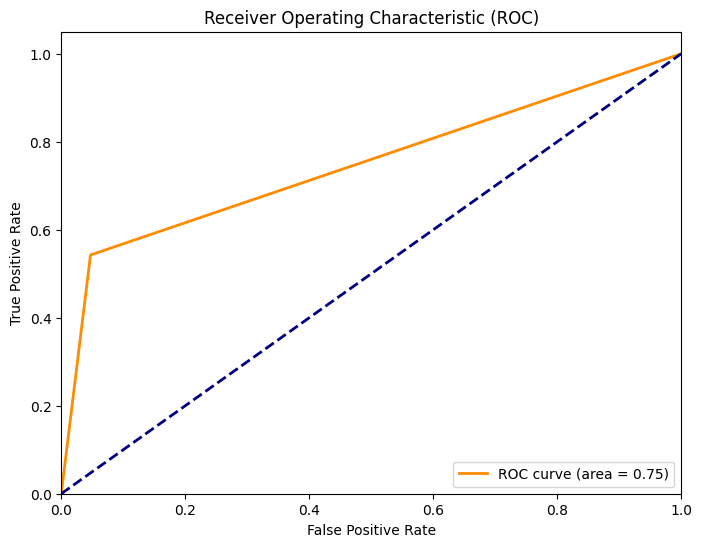

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# assume y_true and y_scores are your true labels and predicted scores, respectively
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
